In [3]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b

I0000 00:00:1695784846.666241 3241676 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

proj_matrix = torch.tensor([[ 1.1839,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.1370,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device=device)
near,far = 0.1, 10.0
proj_matrix = torch.tensor(getProjectionMatrix(near,far, 2.9, 2.9), device=device)
print(proj_matrix)

device

tensor([[ 0.1214,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.1214,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0101, -0.1010],
        [ 0.0000,  0.0000,  1.0000,  0.0000]], device='cuda:0')


/var/tmp/ipykernel_3241676/3885846317.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(near,far, 2.9, 2.9), device=device)


device(type='cuda')

In [34]:
def _open_gl_projection_matrix(h, w, fx, fy, cx, cy, near, far):
    # transform from cv2 camera coordinates to opengl (flipping sign of y and z)
    view = np.eye(4)
    view[1:3] *= -1

    # see http://ksimek.github.io/2013/06/03/calibrated_cameras_in_opengl/
    persp = np.zeros((4, 4))
    persp[0, 0] = fx
    persp[1, 1] = fy
    persp[0, 2] = cx
    persp[1, 2] = cy
    persp[2, 2] = near + far
    persp[2, 3] = near * far
    persp[3, 2] = -1
    # transform the camera matrix from cv2 to opengl as well (flipping sign of y and z)
    persp[:2, 1:3] *= -1

    # The origin of the image is in the *center* of the top left pixel.
    # The orthographic matrix should map the whole image *area* into the opengl NDC, therefore the -.5 below:

    left, right, bottom, top = -0.5, w - 0.5, -0.5, h - 0.5
    orth = np.array(
        [
            (2 / (right - left), 0, 0, -(right + left) / (right - left)),
            (0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)),
            (0, 0, -2 / (far - near), -(far + near) / (far - near)),
            (0, 0, 0, 1),
        ]
    )
    return orth @ persp @ view

proj_matrix = torch.tensor(_open_gl_projection_matrix(100.0, 100.0, 10.0, 10.0, 50.0, 50.0, near,far).astype(np.float32), device=device)
print(proj_matrix)


tensor([[ 0.2000,  0.0000,  0.0100,  0.0000],
        [ 0.0000,  0.2000,  0.0100,  0.0000],
        [ 0.0000,  0.0000,  1.0202, -0.2020],
        [ 0.0000,  0.0000,  1.0000,  0.0000]], device='cuda:0')


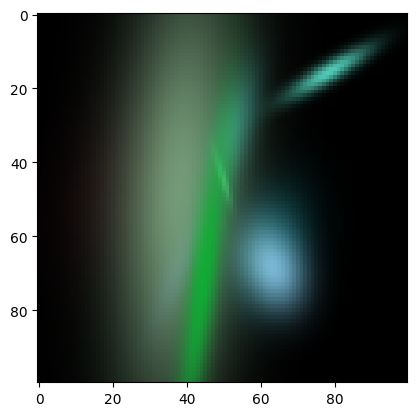

In [35]:
N = 10
means3D = torch.rand((N, 3)).cuda() - 0.5 + torch.tensor([0.0, 0.0, 1.0],device= device)
means2D = torch.zeros((N, 3)).cuda()
colors = torch.rand((N, 3)).cuda()
opacity = torch.rand((N, 1)).cuda() + 0.1
scales = torch.rand((N, 3)).cuda() * 0.1
rotations = torch.rand((N, 4)).cuda()


raster_settings = GaussianRasterizationSettings(
    image_height=int(100),
    image_width=int(100),
    tanfovx=0.8,
    tanfovy=0.4,
    bg=torch.tensor([0.,0.,0.]).cuda(),
    scale_modifier=1.0,
    viewmatrix=torch.eye(4).cuda(),
    projmatrix=proj_matrix,
    sh_degree=0,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)


ground_truth_image, radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors,
    opacities = opacity,
    scales = scales,
    rotations = rotations,
    cov3D_precomp = None
)

# img_data = b.load_image_from_file("mustard.jpeg")
# print(np.array(img_data).shape)
# ground_truth_image = torch.tensor(np.moveaxis(np.array(img_data) / 255.0,-1,0),device=device)
# plt.imshow(np.moveaxis(ground_truth_image.cpu().numpy(),0,-1))
plt.imshow(np.moveaxis(ground_truth_image.cpu().numpy(),0,-1))

/var/tmp/ipykernel_3241676/2505512644.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(
/var/tmp/ipykernel_3241676/2505512644.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.05 * torch.rand((N, 3)),requires_grad=True,device=device)
0.05815562233328819:   1%|          | 9/1000 [00:00<00:11, 87.68it/s]

4.473498847801238e-05: 100%|██████████| 1000/1000 [00:10<00:00, 92.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


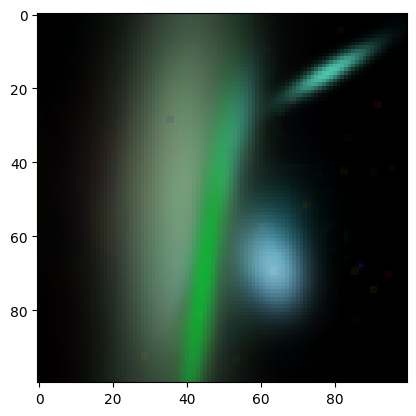

In [36]:
N = 200000
means3D = torch.tensor(
    torch.rand((N, 3),requires_grad=True).cuda() - 0.5 + torch.tensor([0.0, 0.0, 1.0],requires_grad=True,device= device)
    ,device=device
    ,requires_grad=True
)
means2D = torch.zeros((N, 3),requires_grad=True, device=device)
colors = torch.rand((N, 3),requires_grad=True,device=device)
opacity = torch.rand((N, 1),requires_grad=True,device=device)
scales = torch.tensor( 0.05 * torch.rand((N, 3)),requires_grad=True,device=device)
rotations = torch.rand((N, 4),requires_grad=True,device=device)


raster_settings = GaussianRasterizationSettings(
    image_height=int(ground_truth_image.shape[1]),
    image_width=int(ground_truth_image.shape[2]),
    tanfovx=0.8,
    tanfovy=0.4,
    bg=torch.tensor([0.,0.,0.]).cuda(),
    scale_modifier=1.0,
    viewmatrix=torch.eye(4).cuda(),
    projmatrix=proj_matrix,
    sh_degree=0,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)

optimizer = torch.optim.Adam([means3D, colors, opacity, scales, rotations ], lr=0.001, eps=1e-15)
images = []

pbar = tqdm(range(1000))
for _ in pbar:
    rendered_image, radii = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors,
        opacities = torch.sigmoid(opacity),
        scales = scales,
        rotations = rotations,
        cov3D_precomp = None
    )
    loss = ((rendered_image - ground_truth_image)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    images.append(rendered_image)
    pbar.set_description(f"{loss.item()}")
    # print(opacity.min(), opacity.max())

plt.imshow(np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1))

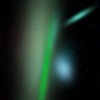

In [37]:
b.get_rgb_image(np.clip(np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1) * 255.0, 0.0, 255.0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


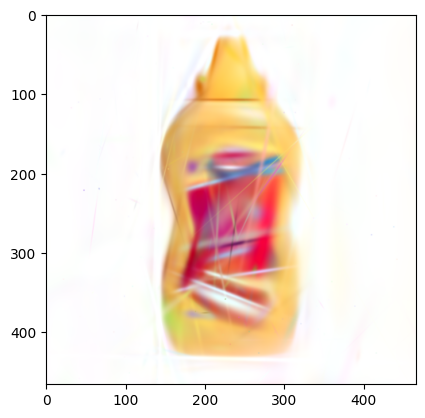

In [13]:
plt.imshow(np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1))

In [9]:

import time
time.time()
dirname = os.path.join("/tmp/", f"{time.time()}")
os.mkdir(dirname)
img = b.get_rgb_image(np.moveaxis(ground_truth_image.cpu().numpy(),0,-1) * 255.0)
viz_images = [
    b.hstack_images(
        [
            b.get_rgb_image(np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1) * 255.0),
            img
        ]
    )
    for rendered_image in images
]

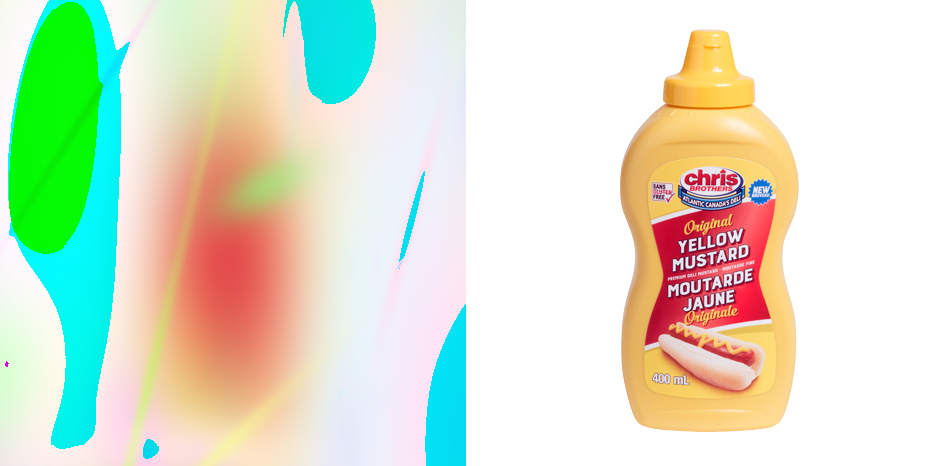

In [12]:
viz_images[100]

In [10]:
b.make_gif_from_pil_images(viz_images, "optim.gif")

In [95]:
for i,image in tqdm(enumerate(viz_images)):
    image.save(os.path.join(dirname, f"{i:05d}.png"))

1000it [02:05,  7.96it/s]


In [98]:
dirname

'/tmp/1695740504.1568244'

In [99]:
!ffmpeg -framerate 10 -i /tmp/1695740504.1568244/%05d.png -c:v libx264 -crf 0 output3.mp4

ffmpeg version 4.3.6-0+deb11u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

In [63]:
import cv2
video = cv2.VideoWriter("test2.avi", cv2.VideoWriter_fourcc('p', 'n', 'g', ' '), 24, (210,100))
for image in viz_images:
    video.write((np.array(image).astype(np.uint8)))
video.release()